# 📘 Quantum Walk — Definition, Circuit, and Minimal Examples

## What is a quantum walk?

The concept of a random walk has existed in mathematics for centuries. Consising on a stochastic process by which a variable changes randomly in successive steps, they have applications in computer science, economics, and game theory among others. Their most representative application in physics is in Markovian chains, where they help simulate a large array of phenomena, from atomic interactions, to galaxy dynamics. 

In it's most simple version, we can imagine a random walk in one dimension, where a particle located in a chain, moves either to the left, or to the right with equal probability at every time step. With the emergence of quantum information theory and quantum computing, the concept of random walk was extended to quantum systems and quantum walks were defined. 

The first immediate result when studying the random walk described above, is that the proability distribution of finding the classical particle at a given time follows a Gaussian distribution, centered at the origin of the walk. However, as we will see in this notebook, the quantum counterpart behaves quite differently.

Let's take a simple example of a one-dimensional quantum walk. $\lvert n \rangle$ will be a state in a given timestep $t$. We want to apply a shift operator $S$ to it such that at time $t+1$ the state is
$$
a\lvert n -1 \rangle + b\lvert n+1 \rangle
$$
Which means that it moves left with an amplitude $a$, or right with an amplitude $b$, and $a$ and $b$ are independent of $n$. However, imposing unitatity on this operation implies that either $a=1, b=0$, or $a=0, b=1$ [2]. We can solve this by introducing an auxilliary state, the "coin" that can take values 0 or 1, and work with the two states $\lvert n, 0 \rangle$ and $\lvert n, 1 \rangle$. 
Then we will require that the shift operator acts in like this:

$$
S\lvert n, 0 \rangle = \lvert n-1, 0 \rangle, \qquad S\lvert n, 1 \rangle = \lvert n+1, 1 \rangle
$$


When simulating the process with a quantum computer, the initial state of the system will tipically be $\lvert n, 0 \rangle$, so to create a superposition in the coin state we will define a coin operator $C$. There is a lot of freedom with the choice of $C$, and it will significantly impact the results of the quantum walk. As a first example however, we will simply use a Hadamard gate such that

$$
H\lvert n, 0 \rangle =  \frac{1}{\sqrt{2}}\lvert n, 0 \rangle + \frac{1}{\sqrt{2}}\lvert n, 1 \rangle 
$$

Then, the quantum walk algorithm will be a succession of $SC$ operations for a chosen number of timesteps. 

Quantum walks can also be extended to more complex graphs, as well as continous time evolution. For more in-depth information, we recomend the following reviews [3, 4, 5]

---

## Applications of quantum walks

- In linear systems, quantum walks after a time $t$ have a variance of $\sigma \propto t$, as opposed to $$\sigma \propto \sqrt{t}$, meaning that they propagate quadratically faster needing a time of order $\mathcal{O}(d)$ to cover a distance $d$ instead of $\mathcal{O}(d^2)$. This speedup becomes exponential when considering higher-dimensional graphs. For example, in a binary tree graph [7], the time to cover a distance $d$ is $\mathcal{O}(2^d)$ for the classical walk, and $\mathcal{O}(d^2)$ for the quantum walk!

- Quantum search: Grover's algorithm[] is one of the most famous quantum algorithms for database search. It can find marked elements in a graph with a time of order $\mathcal{O}(\sqrt{N}M)$, where $N$ is the number of elements, and $M$ longest distance between two elements. However, quantum walks, can do better:
    - In a Hypercube of $N=2^n$ vertices, Grover's search takes a time of order $\mathcal{O}(\sqrt{N}\log{N})$, and a quantum walk takes $\mathcal{O}(\sqrt{N})$
    - An even more stricking case is the one of a $\sqrt{N}\times \sqrt{N}$ grid, where the traditional quantum searh has no speeup. Again, here the quantum walk achives the result in $\mathcal{O}(\sqrt{N})$ steps
    - Further examples with speedups include element-distinctness problems and their derivates, for example triangle finding, where quantum walks perform better than other quantum search algorithms.

- An example use case in applied science is photosynthesis modelling [10] , where a quantum was used to model the interaction of photons with the cloriphyl complex in plants.
---

## Circuit implementation of the quantum walk

The steps to implement a quantum walk as a ciruit are the following:

1. Initialization of the system: We need to define a register of qubits that will contain the position of the simulated particle. This register will store an integer number in binary form. In this notebook we will place the particle roughly in the center of the register range. For example if we have 4 qubits, we will initialize them as $\lvert 1000\rangle$, meaning the particle will be in position 7 of the range (0,15).

2. Quantum walk loop: We will iterate these steps a number of times corresponding to the chosen lenght of our quantum walk:
    2.1 Placing the coin in a superposition: We apply the coin operator $C$ to the coin register, for example a Hadamard gate. This is the quantum equivalent of the classical coin flip
    2.2 Apply shift operator S, consisting on an addition and subtraction operators

    $$
    S = S_+ + S- = \lvert 1 \rangle\langle 1 \lvert \otimes \sum_{j}\lvert j+1\rangle \langle j\lvert \quad+\quad  \lvert 0 \rangle\langle 0\lvert \otimes \sum_{j}\lvert j-1\rangle \langle j\lvert
    $$

    This will be implemented through a X gate controlled by the coin qubit, to select the addition when it is in the state $\lvert1\rangle$ and the subtraction when it is in the state $\lvert0\rangle$. The tricky part is how to actually perform the additions and subtractions. Since we are working in a binary register, for a given digit, we will need to place controls on the less significant digits, to decide wehter it should be turned to 1 or 0. The algorithm will iterate through all the digits at every step of the walk, once for the addition operator, and once for the subtraction one.

    2.3 Apply X gates to the position register to revert reset the qubits whose value "passed" onto the more significant qubits: For example if we have the state $\lvert 01 \rangle$ and we add +1 to it, the result of the multi-controlled gate will be $\lvert 11 \rangle$ which means we added +2!. We must then reset the first qubit to 0, $\lvert 10 \rangle$.

3. Measurement of the position register: We finally place measurements on all the qubits (except the coin qubit) in the Z-basis, and convert the results from binary to decimal representation. After a number of iterations of the algorithm, we can make a histogram to visualize the probability distribution of the quantum walk.

 
---
## References


[2] D. Meyer. From quantum cellular automata to quantum lattice gases, Journal of StatisticaPhysics, 85:551-574, 1996. Also quant-ph/9604003.

[6] A. Childs, E. Farhi, S. Gutmann. An example of the diﬀerence between quantum and clas-
sical random walks. Journal of Quantum Information Processing, 1:35, 2002. Also quant-
ph/0103020.

[10]Engel GS, Calhoun TR, Read EL, Ahn TK, Mancal T, Cheng YC et al. (2007). Evidence for wavelike energy transfer through quantum coherence in photosynthetic systems. Nature 446 (7137): 782–6.

### Imports

In [841]:
from qilisdk.speqtrum import SpeQtrum

import os
from collections import Counter
import matplotlib.pyplot as plt

from qilisdk.backends import QutipBackend
from qilisdk.digital import Circuit, H, CNOT, M, X, T, S
from qilisdk.functionals import Sampling

import matplotlib.pyplot as plt
import numpy as np

We select the Qutip backend of QiliSDK to build the circuits

In [842]:
client = None
backend = QutipBackend()

### Definition of Addition/Subtraction functions

Here we define the addition and subtraction gates:

Addition: 
- We loop starting from least significant qubit, and for each qubit in the position register we define the control qubits that include the coin qubit and all the less significant qubits.
- We then apply a multi-controlled X gate on the qubit.
- We apply an X gate to flip it's state after the information has passed onto the next qubit.

Subtraction:

- We repeat the steps for the addition but in reverse order


In [860]:
def apply_addition(circuit, position_register, coin):

    for i, q in enumerate(reversed(position_register)):
        actual_index = len(position_register) - 1 - i
        controls = position_register[actual_index+1:] + [coin]

        circuit.add(X(qubit = q).controlled(*controls))

        if i < len(position_register)-1:
            circuit.add(X(q))

def apply_subtraction(circuit, position_register, coin):
    for i, q in enumerate(position_register):

        controls = position_register[i+1:] + [coin]
        
        circuit.add(X(qubit = q).controlled(*controls))

        if i < len(position_register)-1:
            circuit.add(X(position_register[i+1]))


### Step function

Contiains the circuit to perform a step of the walker, which includes placing the coin qubit in a superposition, and applying the addition and subtraction operators on the position register, with and X gate on the coin in between them to activate the subtraction.

In [861]:
def walk_step(circuit, position_register, coin):

    # Create superposition in coin qubit
    circuit.add(H(coin))
    circuit.add(X(coin))
    apply_addition(circuit, position_register, coin)
    circuit.add(X(coin))
    apply_subtraction(circuit, position_register, coin)

### Walking algorithm

Contains an initialization of the position register and a loop containing a number of random walk steps that we chose, and finally the measurement operation on the position register.

In [864]:
def quantum_walk(circuit, position_register, coin, n_steps):
    #Initial state of graph register
    circuit.add(X(position_register[0]))
    #Initial state of coin corresponding to $|down>$ state
    circuit.add(X(coin)) 

    for _ in range(n_steps):
        walk_step(circuit, position_register, coin)

    circuit.add(M(*position_register))

## Main program

We will use 6 qubits as an exmaple:

0-5 will encode the position in the graph as a binary number (e.g. |000000> is position 0, |000101> is position 5, |111111> is position 63)

6 will be the coin qubit

In [867]:
N_REG  = 6
ACTIVE = [0, 1, 2, 3, 4, 5]
SHOTS  = 100


circuit = Circuit(N_REG)

#Separate position register from coin qubit
position_register = ACTIVE[:-1]
coin = ACTIVE[-1]

n_steps = 1

quantum_walk(circuit, position_register, coin, n_steps)



### Visual representation

We can see a drawing of the circuit for 1 step of the walk. Here the initialization, addition, and subtraction steps can be seen clearly, with the measurement at the end

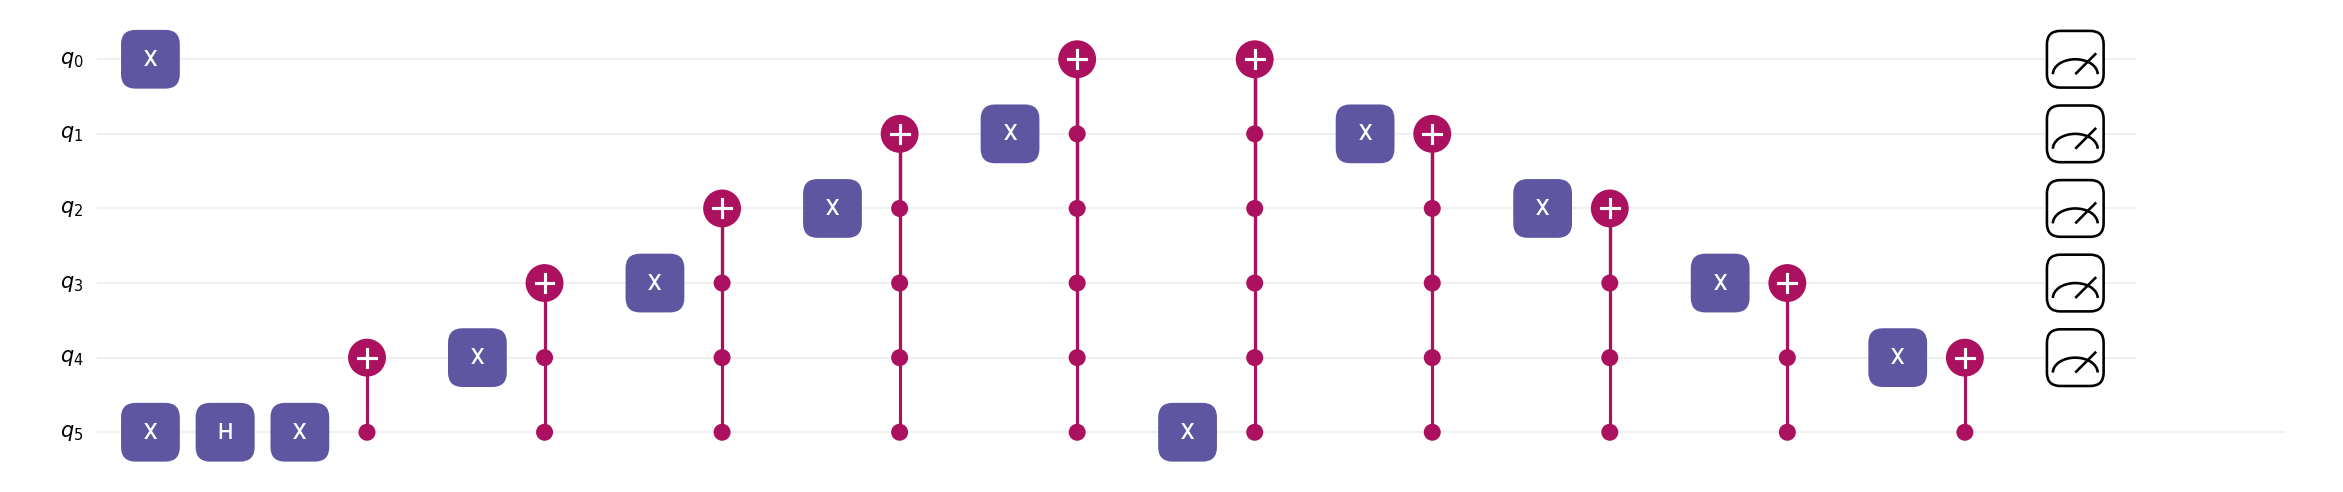

In [868]:
circuit.draw()

## Execution

The next step would be to execute the circuit with the sampling of QiliSKD. However, we will encounter an error, stating that controlled gates with 2 control qubits are not supported. This applies to all our multi-controlled X gates required for the position tracking of the state. 

Until a feature is added to perform those directly by the sampler, we need to find an alternative, which consists on decomposing the controlled gates into CNOT gates and single qubit gates. A modification of the algorithm to accomodate for that is shown in the cells below

In [848]:
result = backend.execute(Sampling(circuit, SHOTS))

QiliSDK | 2025-10-16 at 18:38:35 | ERROR | ❌ Controlled gate with 2 control qubits not supported


UnsupportedGateError: 

## Decomposing Multi-controlled gates

We implement a function that takes a gate with several controls and decomposes it into CNOT gates and single-qubit gates

If the number of controls is larger than 2 in calls the function reduce_dimensionality that takes two control qubits and an ancilla qubit and combines the conditionals of the two controls in the ancilla. Then the ancilla is added as a control, the new lists of controls and ancillas is returned. 

Once there's only 2 controls (or in the reduce_dimensionality function) the Toffoli gate is applied, which has an expression in terms of CNOTs and one-qubit gates. This allows to decompose any multi-controlled gate provided we have enough ancilla qubits

In [849]:
def add_multicontrolled_decomposed(circuit, target, controls, ancillas):
    """
    Decomposes multi-controlled X gate into CNOTs and single-qubit gates,
    """
    if len(controls) == 1:
        circuit.add(CNOT(controls[0], target))
    elif len(controls) == 2:
        add_toffoli(circuit, target, controls)
    else:
        # Prepare ancilla
        new_controls, new_ancillas, used_ancilla = reduce_one_control(circuit, controls, ancillas)
        # Call function recursively
        add_multicontrolled_decomposed(circuit, target, new_controls, new_ancillas)
        # Uncompute ancilla (reverse Toffoli)
        add_toffoli(circuit, used_ancilla, controls[:2])

 
def add_toffoli(c, t, controls):
    # redefine control variables (c=circuit, t=target)
    c1 = controls[0]
    c2 = controls[1]

    #toffoli circuit
    c.add(H(t))
    c.add(CNOT(c1, t))
    c.add(T(t).adjoint())
    c.add(CNOT(c2, t))
    c.add(T(t))
    c.add(CNOT(c1, t))
    c.add(T(t).adjoint())
    c.add(CNOT(c2, t))
    c.add(T(t))
    c.add(T(c1))
    c.add(H(t))
    c.add(CNOT(c2, c1))
    c.add(T(c2))
    c.add(T(c1).adjoint())
    c.add(CNOT(c2, c1))
        

def reduce_one_control(circuit, controls, ancillas):
    """
    Uses an ancilla qubit to reduce the number of controls by one.
    """
    if len(ancillas) == 0:
        raise ValueError("Not enough ancilla qubits")
    c1 = controls[0]
    c2 = controls[1]
    anc = ancillas[0]
    # Compute anc = c1 AND c2
    add_toffoli(circuit, anc, [c1, c2])
    # Replace first two controls by ancilla
    new_controls = [anc] + controls[2:]
    #Eliminate ancilla from available list
    new_ancillas = ancillas[1:]
    return new_controls, new_ancillas, anc

## Updated algorithm

The rest of the algorithm is the same, only that we need to be more careful with how we manage the position and ancilla registers

In [850]:
def apply_addition(circuit, position_register, ancilla_register, coin):

    for i, q in enumerate(reversed(position_register)):
        actual_index = len(position_register) - 1 - i
        controls = position_register[actual_index+1:] + [coin]

        #circuit.add(X(qubit = q).controlled(*controls))
        add_multicontrolled_decomposed(circuit, q, controls, ancilla_register)

        if i < len(position_register)-1:
            circuit.add(X(q))

def apply_subtraction(circuit, position_register, ancilla_register, coin):

    for i, q in enumerate(position_register):

        controls = position_register[i+1:] + [coin]
        
        #circuit.add(X(qubit = q).controlled(*controls))
        add_multicontrolled_decomposed(circuit, q, controls, ancilla_register)

        if i < len(position_register)-1:
            circuit.add(X(position_register[i+1]))



def walk_step(circuit, position_register, ancilla_register, coin):

    # Create superposition in coin qubit
    circuit.add(H(coin))
    circuit.add(X(coin))

    apply_addition(circuit, position_register, ancilla_register, coin)
    circuit.add(X(coin))
    apply_subtraction(circuit, position_register, ancilla_register, coin)
    circuit.add(X(coin))



def quantum_walk(circuit, position_register, ancilla_register, coin, n_steps):

    #Initial state of graph register
    circuit.add(X(position_register[0]))
    
    for _ in range(n_steps):
        walk_step(circuit, position_register, ancilla_register, coin)

    circuit.add(M(*position_register))

## Main program

Once we define the list of available qubits, we need to separate them into the position and ancilla registers, checking that if we take $n$ position qubits, the ancilla contains at least $n-2$ qubits.

In [851]:
N_REG  = 9
ACTIVE = [i for i in range(N_REG)] #Additionally a custom list of active qubits can be defined
SHOTS  = 10000
n_steps = 5

circuit = Circuit(N_REG)

available_qubits = len(ACTIVE)

coin = ACTIVE[-1]

position_register_size = available_qubits//2 + (0 if available_qubits%2 == 0 else 1) #For odd number of qubits we can use half the total number plus 1
position_register = ACTIVE[0: position_register_size]

ancilla_size = available_qubits - position_register_size -1
ancilla_register = ACTIVE[position_register_size:available_qubits-1]

#Display main information about register partition
print("List of active qubits:",ACTIVE)
print("List of quantum walk qubits:", position_register," size:", position_register_size)
print("List of ancilla qubits:", ancilla_register, "size:", ancilla_size)
print("Coin qubit", [coin])

List of active qubits: [0, 1, 2, 3, 4, 5, 6, 7, 8]
List of quantum walk qubits: [0, 1, 2, 3, 4]  size: 5
List of ancilla qubits: [5, 6, 7] size: 3
Coin qubit [8]


## Execution

Now we can build the circuit with the modified algorithm and execute it using the sampler

In [852]:
quantum_walk(circuit, position_register, ancilla_register, coin, n_steps)
#circuit.draw() #uncomment to view full decomposed circuit, use for small circuits only
result = backend.execute(Sampling(circuit, SHOTS)) 

## Plotting

In order to plot the results we first convert the bit strings into integers, and store them along with their simulation results. Then we plot a histogram of the obtained values

In [854]:
def plot_result_histogram(results, title="Quantum Walk Results", plot_type='probability', 
                        figsize=(12, 6), color='steelblue', show_values=True):
    """
    Enhanced function to plot quantum walk results with multiple options
    
    Parameters:
    - results: Counter or dict with {position: count} or {binary_string: count}
    - title: plot title
    - plot_type: 'probability', 'counts', or 'log'
    - figsize: figure size
    - color: bar color
    - show_values: whether to show values on bars
    """
    
    # Process results
    positions = []
    counts = []
    
    for key, count in results.items():
        if isinstance(key, str):
            positions.append(int(key, 2))
        else:
            positions.append(key)
        counts.append(count)
    
    # Sort by position
    sorted_indices = np.argsort(positions)
    positions = [positions[i] for i in sorted_indices]
    counts = [counts[i] for i in sorted_indices]
    
    # Calculate y-values based on plot type
    if plot_type == 'probability':
        total = sum(counts)
        y_values = [count / total for count in counts]
        ylabel = 'Probability'
    elif plot_type == 'log':
        y_values = [np.log10(count + 1) for count in counts]  # +1 to avoid log(0)
        ylabel = 'Log10(Count + 1)'
    else:  # counts
        y_values = counts
        ylabel = 'Counts'
    
    # Create plot
    plt.figure(figsize=figsize)
    bars = plt.bar(positions, y_values, alpha=0.7, color=color, 
                   edgecolor='darkblue', linewidth=0.8)
    
    # Styling
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Position', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Customize x-axis
    plt.xticks(positions, fontsize=10)
    if len(positions) > 15:
        plt.xticks(positions[::2])  # Show every other tick for crowded plots
    
    # Add value labels
    if show_values:
        for bar, count, pos in zip(bars, counts, positions):
            height = bar.get_height()
            if plot_type == 'probability':
                label = f'{height:.3f}'
            elif plot_type == 'log':
                label = f'{count}'
            else:
                label = f'{count}'
            
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01 * max(y_values),
                    label, ha='center', va='bottom', fontsize=8, rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    return positions, counts

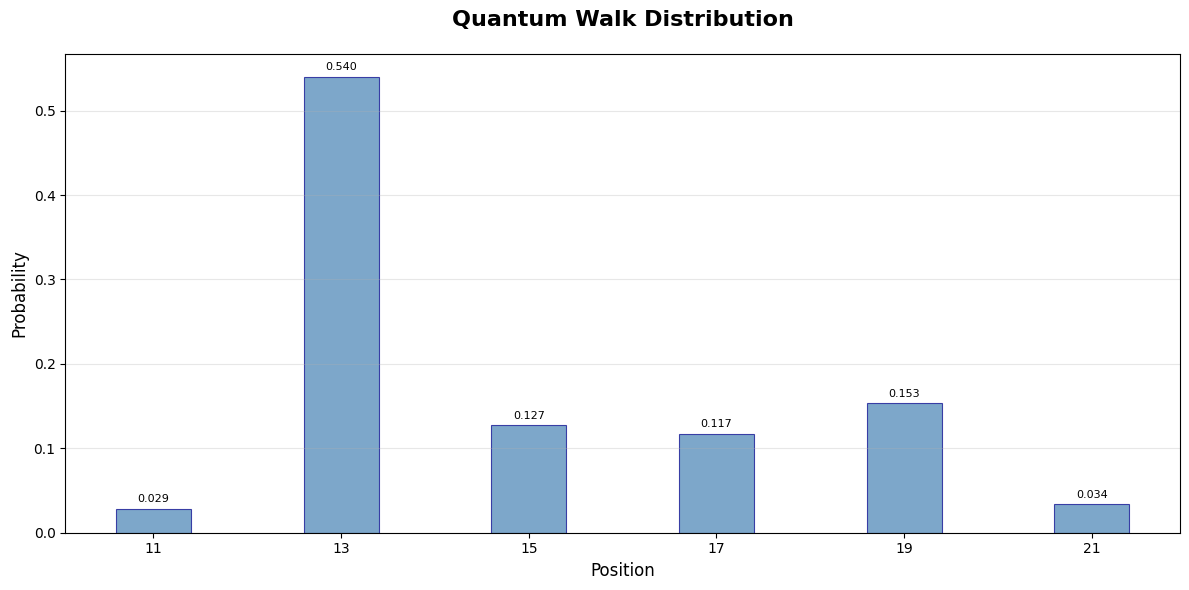

([11, 13, 15, 17, 19, 21], [286, 5403, 1273, 1170, 1531, 337])

In [855]:
plot_result_histogram(result.samples, "Quantum Walk Distribution")

As you can observe, this distribution is biased to one side instead of being symmetric. This is due to the initialization of our coin qubit, which started in the state $\lvert 0\rangle$. As mentioned above, the choice of initialization of the coin affects the distribution of the results. In this case, the application of Hadamard gates on the coin qubit at each time step favours the subtraction operator due to the asymetry in the diagonal terms of the Hadamard transformation. We can chose a different initialization and see how the results change:

In [856]:
def quantum_walk(circuit, position_register, ancilla_register, coin, n_steps):

    #Initial state of graph register
    circuit.add(X(position_register[0]))
    
    #Alternative initialization
    circuit.add(H(coin))
    circuit.add(S(coin))

    for _ in range(n_steps):
        walk_step(circuit, position_register, ancilla_register, coin)

    circuit.add(M(*position_register))

In [857]:
circuit = Circuit(N_REG)

quantum_walk(circuit, position_register, ancilla_register, coin, n_steps)
result = backend.execute(Sampling(circuit, SHOTS)) 

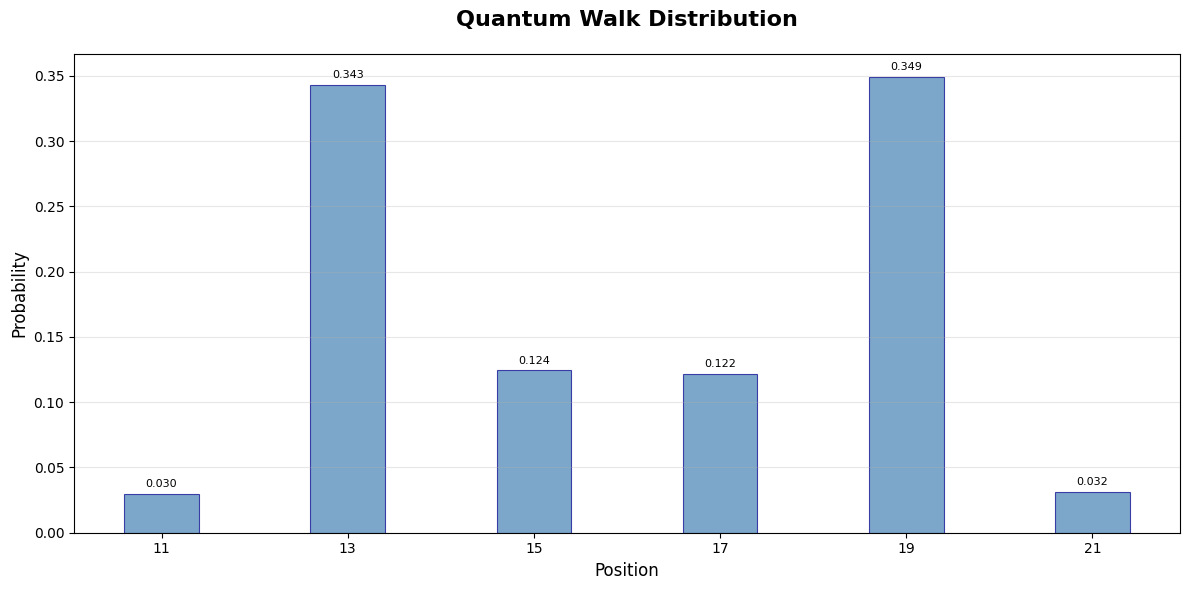

([11, 13, 15, 17, 19, 21], [297, 3432, 1244, 1218, 3494, 315])

In [858]:
plot_result_histogram(result.samples, "Quantum Walk Distribution")